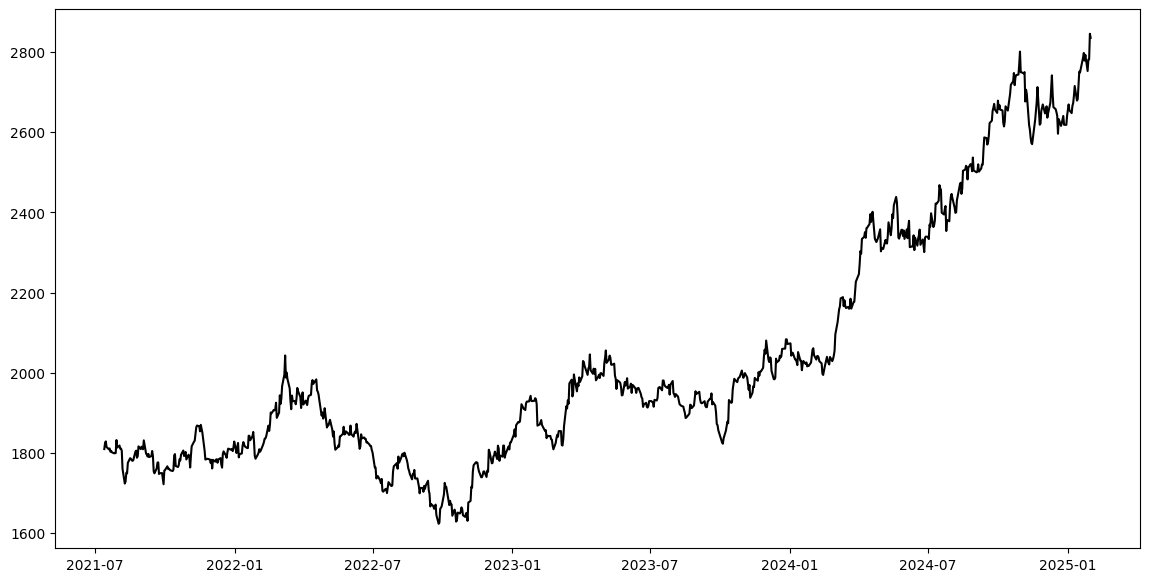

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # Ensure F is imported for activation functions
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings
import matplotlib.dates as mdates

# Load and prepare data
df = pd.read_csv('Gold Futures Historical Data_3Yr.csv')
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Transform columns to numerical format
num_cols = df.columns.drop(['Date'])
df[num_cols] = df[num_cols].replace({',': ''}, regex=True)
df[num_cols] = df[num_cols].astype('float64')


# Features to include
features = ['Price', 'Open', 'High', 'Low']
data = df[features].values

# Window width
window_width = 30  # Adjusted window width for experimentation

# Data scaling (scale each feature individually)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)



# Prepare sequences and corresponding dates
X, y_full, dates = [], [], []
for i in range(window_width, len(data_scaled)):
    X.append(data_scaled[i - window_width:i])
    y_full.append(data_scaled[i, 0])  # Assuming 'Price' is the target
    dates.append(df['Date'].iloc[i])

X = np.array(X)
y_full = np.array(y_full)
dates = np.array(dates)


# Define the inverse_transform function globally
def inverse_transform(y_scaled):
    """
    Inverse transform the scaled 'Price' values back to the original scale.
    Assumes that the scaler was fit on all features.
    """
    y_scaled = np.array(y_scaled).reshape(-1, 1)
    # Create a placeholder for other features with zeros
    zeros = np.zeros((y_scaled.shape[0], len(features) - 1))
    y_combined = np.hstack((y_scaled, zeros))
    y_inv = scaler.inverse_transform(y_combined)
    return y_inv[:, 0]


# At the end of the full-set original price cell, after plotting:
full_dates = dates        # Save the original full-set dates (e.g. shape (N_full,))
full_actual = inverse_transform(y_full)   # Save the actual price curve (e.g. shape (N_full,))


# Plotting the full dataset with predictions over validation and test sets only
plt.figure(figsize=(14, 7))

#all_prices_inv_full = scaler.inverse_transform(data_scaled)[:, 0]
#plt.plot(df['Date'], all_prices_inv, color='black', label='Actual Price')

# Actual Price
plt.plot(dates, full_actual, color='black', label='Actual Price')



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # For activation functions
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings
import matplotlib.dates as mdates

# Additional imports for SVM and BOOST
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

### DATA LOADING, CLEANING, AND PREPARATION ###
df = pd.read_csv('Gold Futures Historical Data_3Yr_Train.csv')
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Transform columns to numerical format
num_cols = df.columns.drop(['Date'])
df[num_cols] = df[num_cols].replace({',': ''}, regex=True)
df[num_cols] = df[num_cols].astype('float64')

# Check for duplicates and nulls (commented out for demonstration)
# assert df.duplicated().sum() == 0, "Duplicate rows found!"
# assert df.isnull().sum().sum() == 0, "Missing values found!"

# Features to include
features = ['Price', 'Open', 'High', 'Low']
data = df[features].values

# Data scaling: scale all four features using MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Window width (number of past days used for prediction)
window_width = 28  # adjust as needed

# Prepare sequences:
X, y, all_dates = [], [], []
for i in range(window_width, len(data_scaled)):
    X.append(data_scaled[i - window_width:i])   # shape: (window_width, 4)
    y.append(data_scaled[i])                    # target: 4D vector
    all_dates.append(df['Date'].iloc[i])

X = np.array(X)  # shape: (num_samples, window_width, 4)
y = np.array(y)  # shape: (num_samples, 4)
all_dates = np.array(all_dates)

# Split data into training and test sets based on date
train_mask = all_dates < pd.to_datetime('2024-07-31')
test_mask  = (all_dates >= pd.to_datetime('2024-07-31')) & (all_dates <= pd.to_datetime('2025-03-01'))

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test   = X[test_mask], y[test_mask]
train_dates = all_dates[train_mask]
test_dates  = all_dates[test_mask]

# Convert to PyTorch tensors for the neural net models
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_test_tensor  = torch.from_numpy(X_test).float()
y_test_tensor  = torch.from_numpy(y_test).float()

# Create TensorDatasets and DataLoaders (for training only)
batch_size = 32  # adjust as needed
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

### MODEL DEFINITION ###
class BaseModel(nn.Module):
    def __init__(self, model_type='LSTM'):
        super(BaseModel, self).__init__()
        self.model_type = model_type
        input_size = len(features)  # 4 features
        
        if model_type == 'LSTM':
            self.rnn = nn.LSTM(
                input_size=input_size,
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.1,
            )
            self.fc = nn.Linear(128, input_size)  # output 4 values
            
        elif model_type == 'GRU':
            self.rnn = nn.GRU(
                input_size=input_size,
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.1,
            )
            self.fc = nn.Linear(128, input_size)
            
        elif model_type == 'RNN':
            self.rnn = nn.RNN(
                input_size=input_size,
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                nonlinearity='relu',
                dropout=0.1,
            )
            self.fc = nn.Linear(128, input_size)
            
        elif model_type == 'CNN':
            self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
            # Output length after two Conv1D with kernel=3 => window_width - 2*(3-1)
            conv_output_length = window_width - 2 * (3 - 1)
            self.fc = nn.Linear(128 * conv_output_length, input_size)
            
        elif model_type == 'EnhancedLSTM':
            self.rnn = nn.LSTM(
                input_size=input_size,
                hidden_size=128,
                num_layers=3,
                batch_first=True,
                dropout=0.2,
            )
            self.dropout = nn.Dropout(0.2)
            self.bn = nn.BatchNorm1d(128)
            self.fc = nn.Linear(128, input_size)
            
        else:
            raise ValueError("Invalid model_type. Choose from 'LSTM', 'GRU', 'RNN', 'CNN', 'EnhancedLSTM'")

    def forward(self, x):
        if self.model_type == 'CNN':
            # x shape: (batch, window_width, 4) -> (batch, 4, window_width)
            x = x.permute(0, 2, 1)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            out = self.fc(x)
        else:
            out, _ = self.rnn(x)
            out = out[:, -1, :]  # last time step output
            # For EnhancedLSTM, optionally apply dropout/batchnorm to out
            if self.model_type == 'EnhancedLSTM':
                out = self.dropout(out)
                out = self.bn(out)
            out = self.fc(out)
        return out  # shape: (batch, 4)

### EARLY STOPPING CLASS ###
class EarlyStopping:
    def __init__(self, patience=150, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
            
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

### TRAINING FUNCTION FOR PYTORCH MODELS ###
def train_and_evaluate_pytorch(model_name):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = BaseModel(model_type=model_name).to(device)
    
    criterion = nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=150)
    early_stopping = EarlyStopping(patience=150, min_delta=0)
    num_epochs = 300
    best_train_loss = float('inf')
    
    best_model_path = f'best_model_{model_name}_4d.pt'
    
    # Load existing model if available
    if os.path.exists(best_model_path):
        model.load_state_dict(torch.load(best_model_path, map_location=device))
        print(f"Loaded existing model for {model_name} from {best_model_path}")
    
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        avg_train_loss = np.mean(train_losses)
        scheduler.step(avg_train_loss)
        early_stopping(avg_train_loss)
        if early_stopping.early_stop:
            print(f"[{model_name}] Early stopping at epoch {epoch + 1}")
            break
        if avg_train_loss < best_train_loss:
            best_train_loss = avg_train_loss
            torch.save(model.state_dict(), best_model_path)
        if (epoch + 1) % 100 == 0 or epoch == 0:
            print(f'[{model_name}] Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.6f}')
    
    # Load the best model
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    return model

### RECURSIVE FORECASTING FUNCTION (for PyTorch models) ###
def recursive_forecast_pytorch(model, initial_window, forecast_horizon):
    model.eval()
    device = next(model.parameters()).device
    preds = []
    current_window = initial_window.clone().to(device)  # shape: (window_width, 4)
    
    for _ in range(forecast_horizon):
        input_tensor = current_window.unsqueeze(0)  # shape: (1, window_width, 4)
        with torch.no_grad():
            pred = model(input_tensor)  # shape: (1, 4)
        pred = pred.squeeze(0)  # shape: (4,)
        preds.append(pred.cpu().numpy())
        # Slide the window
        current_window = torch.cat((current_window[1:], pred.unsqueeze(0)), dim=0)
    
    return np.array(preds)  # shape: (forecast_horizon, 4)

########################################
# SVM AND BOOST (XGBoost) TRAINING/FORECAST
########################################

def train_and_evaluate_sklearn(model_name):
    """
    Trains a scikit-learn model (SVM or XGBoost) to predict 4 output features.
    Returns a fitted scikit-learn model object.
    """
    # Reshape X from (num_samples, window_width, 4) to (num_samples, window_width*4)
    X_train_2d = X_train.reshape(X_train.shape[0], -1)  # shape: (N, window_width*4)
    # y_train is shape (N, 4)
    
    if model_name == 'SVM':
        # Example: Using RBF kernel, can tweak C, epsilon, etc.
        base_svr = SVR(kernel='rbf', C=100, epsilon=0.01)
        model = MultiOutputRegressor(base_svr)
    elif model_name == 'BOOST':
        # Example: XGBoost regressor
        base_xgb = XGBRegressor(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=0
        )
        model = MultiOutputRegressor(base_xgb)
    else:
        raise ValueError("Invalid model_name for sklearn. Use 'SVM' or 'BOOST'.")
    
    # Fit the model
    model.fit(X_train_2d, y_train)
    return model

def recursive_forecast_sklearn(model, initial_window, forecast_horizon):
    """
    Recursively predict the next 'forecast_horizon' days using an sklearn model.
    initial_window: shape (window_width, 4) (NumPy array)
    model: fitted sklearn multioutput model
    """
    preds = []
    current_window = initial_window.copy()  # shape: (window_width, 4)
    
    for _ in range(forecast_horizon):
        # Reshape current_window to (1, window_width*4)
        input_2d = current_window.reshape(1, -1)
        pred = model.predict(input_2d)  # shape: (1, 4)
        pred = pred[0]                 # shape: (4,)
        preds.append(pred)
        # Slide the window: drop first row, append pred
        current_window = np.vstack([current_window[1:], pred])
    
    return np.array(preds)

########################################
# MASTER TRAIN-AND-FORECAST DISPATCH
########################################
def train_and_forecast(model_name):
    """
    Wrapper function that:
      1. Trains the model (PyTorch or sklearn).
      2. Performs recursive forecast on the entire test set horizon.
      3. Returns the predictions (un-scaled) for the 'Price' column.
    """
    forecast_horizon = len(test_dates)
    
    if model_name in ['LSTM', 'GRU', 'RNN', 'CNN', 'EnhancedLSTM']:
        # Train with PyTorch
        model = train_and_evaluate_pytorch(model_name)
        # Use the last training window as initial window
        initial_window = X_train_tensor[-1]  # shape: (window_width, 4)
        # Recursive forecast
        test_preds_scaled = recursive_forecast_pytorch(model, initial_window, forecast_horizon)
        
    elif model_name in ['SVM', 'BOOST']:
        # Train with sklearn
        model = train_and_evaluate_sklearn(model_name)
        # Use the last training window as initial window (NumPy array)
        initial_window = X_train[-1]  # shape: (window_width, 4)
        # Recursive forecast
        test_preds_scaled = recursive_forecast_sklearn(model, initial_window, forecast_horizon)
        
    else:
        raise ValueError("Unknown model name!")
    
    # Inverse transform predictions to get actual scale
    test_preds_inv = scaler.inverse_transform(test_preds_scaled)
    # Return the first column = predicted 'Price'
    return test_preds_inv[:, 0]

### RUN TRAIN AND FORECAST FOR MULTIPLE MODELS ###
model_names = ['LSTM', 'GRU', 'RNN', 'CNN', 'EnhancedLSTM', 'SVM', 'BOOST']
all_forecasts = {}

for model_name in model_names:
    print(f"\nTraining and forecasting with model: {model_name}")
    predicted_prices = train_and_forecast(model_name)
    all_forecasts[model_name] = predicted_prices

### PLOTTING RESULTS ###
plt.figure(figsize=(14, 7))

# Plot actual prices for all dates
all_prices_inv = scaler.inverse_transform(data_scaled)[:, 0]
plt.plot(df['Date'], all_prices_inv, color='black', label='Actual Price')

# Highlight the test period
plt.axvspan(pd.to_datetime('2024-07-31'), df['Date'].iloc[-1],
            color='yellow', alpha=0.1, label='Test Period')

# Define colors for models (extend as needed)
model_colors = {
    'LSTM': 'red',
    'GRU': 'blue',
    'RNN': 'green',
    'CNN': 'orange',
    'EnhancedLSTM': 'purple',
    'SVM': 'magenta',
    'BOOST': 'cyan'
}

# Plot forecasts
for model_name, forecast in all_forecasts.items():
    plt.plot(test_dates, forecast, color=model_colors[model_name],
             linestyle='--', linewidth=2, label=f'{model_name} Forecast')

plt.title('Gold Price Prediction: Recursive Forecast Over Test Window')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Zoomed-in Plot (starting from 2024-09-01 or 2024-07-31 for clarity)
plt.figure(figsize=(14, 7))
for model_name, forecast in all_forecasts.items():
    plt.plot(test_dates, forecast, color=model_colors[model_name],
             linestyle='--', linewidth=2, label=f'{model_name} Forecast')
plt.title('Zoomed-In Gold Price Recursive Forecast (2024-07-31 to 2025-03-01)')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'xgboost'


Training and forecasting with model: LSTM
[LSTM] Epoch 1/300, Training Loss: 0.013157
[LSTM] Epoch 100/300, Training Loss: 0.000393
[LSTM] Epoch 200/300, Training Loss: 0.000193
[LSTM] Epoch 300/300, Training Loss: 0.000171

Training and forecasting with model: GRU
[GRU] Epoch 1/300, Training Loss: 0.009656


/tmp/ipykernel_1535867/595138861.py:219: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


[GRU] Epoch 100/300, Training Loss: 0.000276
[GRU] Epoch 200/300, Training Loss: 0.000184
[GRU] Epoch 300/300, Training Loss: 0.000180

Training and forecasting with model: RNN
[RNN] Epoch 1/300, Training Loss: 0.014068


/tmp/ipykernel_1535867/595138861.py:219: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


[RNN] Epoch 100/300, Training Loss: 0.000255
[RNN] Epoch 200/300, Training Loss: 0.000293
[RNN] Epoch 300/300, Training Loss: 0.000196

Training and forecasting with model: CNN
[CNN] Epoch 1/300, Training Loss: 0.008721


/tmp/ipykernel_1535867/595138861.py:219: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


[CNN] Epoch 100/300, Training Loss: 0.000514
[CNN] Epoch 200/300, Training Loss: 0.000283
[CNN] Epoch 300/300, Training Loss: 0.000320


/tmp/ipykernel_1535867/595138861.py:219: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


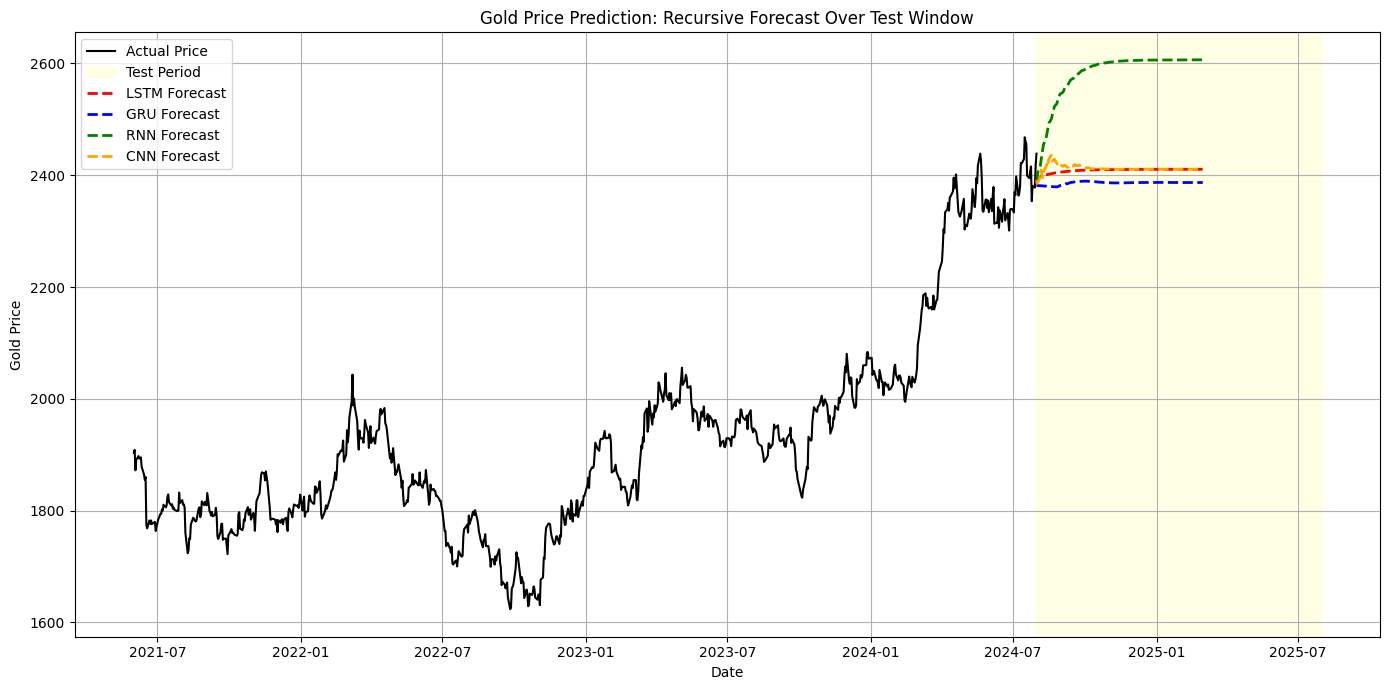

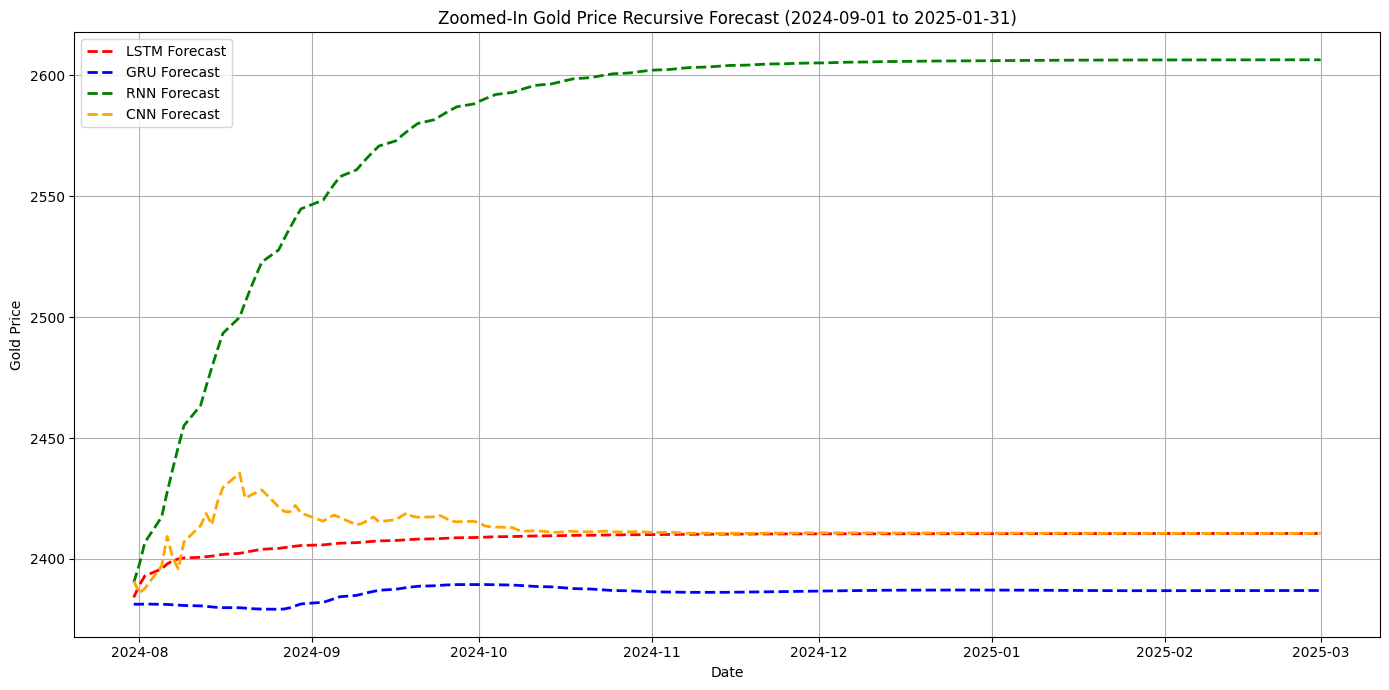

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # For activation functions
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings
import matplotlib.dates as mdates

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

### DATA LOADING, CLEANING, AND PREPARATION ###
df = pd.read_csv('Gold Futures Historical Data_3Yr_Train.csv')
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Transform columns to numerical format
num_cols = df.columns.drop(['Date'])
df[num_cols] = df[num_cols].replace({',': ''}, regex=True)
df[num_cols] = df[num_cols].astype('float64')

# Check for duplicates and nulls
#assert df.duplicated().sum() == 0, "Duplicate rows found!"
#assert df.isnull().sum().sum() == 0, "Missing values found!"

# Features to include
features = ['Price', 'Open', 'High', 'Low']
data = df[features].values

# Data scaling: scale all four features using MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Window width (number of past days used for prediction)
window_width = 28  # adjust as needed

# Prepare sequences:
# For each sample, we take the previous window_width days as input,
# and use the entire 4‑dimensional vector of the day immediately following as the target.
X, y, all_dates = [], [], []
for i in range(window_width, len(data_scaled)):
    X.append(data_scaled[i - window_width:i])   # shape: (window_width, 4)
    y.append(data_scaled[i])                      # target: 4-dimensional vector
    all_dates.append(df['Date'].iloc[i])

X = np.array(X)  # shape: (num_samples, window_width, 4)
y = np.array(y)  # shape: (num_samples, 4)
all_dates = np.array(all_dates)

# Split data into training and test sets based on date.
# Training: all dates before 2024-09-01; Test: from 2024-09-01 onward.
train_mask = all_dates < pd.to_datetime('2024-07-31')
#test_mask  = all_dates >= pd.to_datetime('2025-01-01')
test_mask   = (all_dates >= pd.to_datetime('2024-07-31')) & (all_dates <= pd.to_datetime('2025-03-01'))

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test   = X[test_mask], y[test_mask]
train_dates = all_dates[train_mask]
test_dates  = all_dates[test_mask]

# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()  # shape: (N, 4)
X_test_tensor  = torch.from_numpy(X_test).float()
y_test_tensor  = torch.from_numpy(y_test).float()

# Create TensorDatasets and DataLoaders (for training only)
batch_size = 32  # adjust as needed
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  # sequential order

### MODEL DEFINITION ###
# The model is modified so that its final layer outputs 4 values.
class BaseModel(nn.Module):
    def __init__(self, model_type='LSTM'):
        super(BaseModel, self).__init__()
        self.model_type = model_type
        input_size = len(features)  # 4 features
        if model_type == 'LSTM':
            self.rnn = nn.LSTM(
                input_size=input_size,
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.1,
            )
            self.fc = nn.Linear(128, input_size)  # output 4 values
        elif model_type == 'GRU':
            self.rnn = nn.GRU(
                input_size=input_size,
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.1,
            )
            self.fc = nn.Linear(128, input_size)
        elif model_type == 'RNN':
            self.rnn = nn.RNN(
                input_size=input_size,
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                nonlinearity='relu',
                dropout=0.1,
            )
            self.fc = nn.Linear(128, input_size)
        elif model_type == 'CNN':
            self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
            conv_output_length = window_width - 2 * (3 - 1)
            self.fc = nn.Linear(128 * conv_output_length, input_size)
        elif model_type == 'EnhancedLSTM':
            self.rnn = nn.LSTM(
                input_size=input_size,
                hidden_size=128,
                num_layers=3,
                batch_first=True,
                dropout=0.2,
            )
            self.dropout = nn.Dropout(0.2)
            self.bn = nn.BatchNorm1d(128)
            self.fc = nn.Linear(128, input_size)
        else:
            raise ValueError("Invalid model_type. Choose from 'LSTM', 'GRU', 'RNN', 'CNN'")

    def forward(self, x):
        if self.model_type == 'CNN':
            # x shape: (batch, window_width, 4) -> (batch, 4, window_width)
            x = x.permute(0, 2, 1)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            out = self.fc(x)

        else:
            # For LSTM, GRU, and RNN:
            out, _ = self.rnn(x)
            out = out[:, -1, :]  # last time step output
            out = self.fc(out)
        return out  # shape: (batch, 4)

### EARLY STOPPING CLASS ###
class EarlyStopping:
    def __init__(self, patience=150, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
            
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

### TRAINING FUNCTION ###
def train_and_evaluate(model_name):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = BaseModel(model_type=model_name).to(device)
    
    criterion = nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=150)
    early_stopping = EarlyStopping(patience=150, min_delta=0)
    num_epochs = 300
    best_train_loss = float('inf')
    
    # Use a new checkpoint filename to avoid loading incompatible weights.
    best_model_path = f'best_model_{model_name}_4d.pt'
    
    # Load existing model if available
    if os.path.exists(best_model_path):
        model.load_state_dict(torch.load(best_model_path, map_location=device))
        print(f"Loaded existing model for {model_name} from {best_model_path}")
    
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        avg_train_loss = np.mean(train_losses)
        scheduler.step(avg_train_loss)
        early_stopping(avg_train_loss)
        if early_stopping.early_stop:
            print(f"[{model_name}] Early stopping at epoch {epoch + 1}")
            break
        if avg_train_loss < best_train_loss:
            best_train_loss = avg_train_loss
            torch.save(model.state_dict(), best_model_path)
        if (epoch + 1) % 100 == 0 or epoch == 0:
            print(f'[{model_name}] Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.6f}')
    
    # Load the best model
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    return model

### RECURSIVE FORECASTING FUNCTION ###
def recursive_forecast(model, initial_window, forecast_horizon, device):
    """
    Recursively predict the next 'forecast_horizon' days.
    
    Parameters:
        model: trained model.
        initial_window: a torch.Tensor of shape (window_width, 4) representing the last known window.
        forecast_horizon: number of days to forecast.
        device: torch device.
        
    Returns:
        predictions: a NumPy array of shape (forecast_horizon, 4) containing the forecasted values.
    """
    model.eval()
    preds = []
    current_window = initial_window.clone().to(device)  # shape: (window_width, 4)
    for _ in range(forecast_horizon):
        input_tensor = current_window.unsqueeze(0)  # shape: (1, window_width, 4)
        with torch.no_grad():
            pred = model(input_tensor)  # shape: (1, 4)
        pred = pred.squeeze(0)  # shape: (4,)
        preds.append(pred.cpu().numpy())
        # Form next window: remove the first row and append the new prediction row.
        current_window = torch.cat((current_window[1:], pred.unsqueeze(0)), dim=0)
    return np.array(preds)  # shape: (forecast_horizon, 4)

### TRAIN AND FORECAST WITH MULTIPLE MODELS ###
model_names = ['LSTM', 'GRU', 'RNN', 'CNN']
all_forecasts = {}  # dictionary to store forecasted prices (first column) for each model

for model_name in model_names:
    print(f"\nTraining and forecasting with model: {model_name}")
    model = train_and_evaluate(model_name)
    # Use the last training window as the initial window for recursive forecasting.
    initial_window = X_train_tensor[-1]  # shape: (window_width, 4)
    forecast_horizon = len(test_dates)     # forecast for each day in the test period
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    test_preds_scaled = recursive_forecast(model, initial_window, forecast_horizon, device)
    test_preds_inv = scaler.inverse_transform(test_preds_scaled)
    predicted_prices = test_preds_inv[:, 0]  # take the predicted 'Price' (first column)
    all_forecasts[model_name] = predicted_prices

### PLOTTING RESULTS ###
# Plot the entire dataset along with the recursive forecast from each model over the test window.
plt.figure(figsize=(14, 7))
# Plot actual prices (inverse transformed) for all dates.
all_prices_inv = scaler.inverse_transform(data_scaled)[:, 0]
plt.plot(df['Date'], all_prices_inv, color='black', label='Actual Price')
# Highlight the test period.
plt.axvspan(pd.to_datetime('2024-07-31'), df['Date'].iloc[-1], color='yellow', alpha=0.1, label='Test Period')
# Define colors for models.
model_colors = {
    'LSTM': 'red',
    'GRU': 'blue',
    'RNN': 'green',
    'CNN': 'orange',
}
# Plot forecast from each model.
for model_name, forecast in all_forecasts.items():
    plt.plot(test_dates, forecast, color=model_colors[model_name], linestyle='--', linewidth=2, label=f'{model_name} Forecast')
plt.title('Gold Price Prediction: Recursive Forecast Over Test Window')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Zoomed-in Plot (starting from 2024-09-01)
plt.figure(figsize=(14, 7))
for model_name, forecast in all_forecasts.items():
    plt.plot(test_dates, forecast, color=model_colors[model_name], linestyle='--', linewidth=2, label=f'{model_name} Forecast')
plt.title('Zoomed-In Gold Price Recursive Forecast (2024-09-01 to 2025-01-31)')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

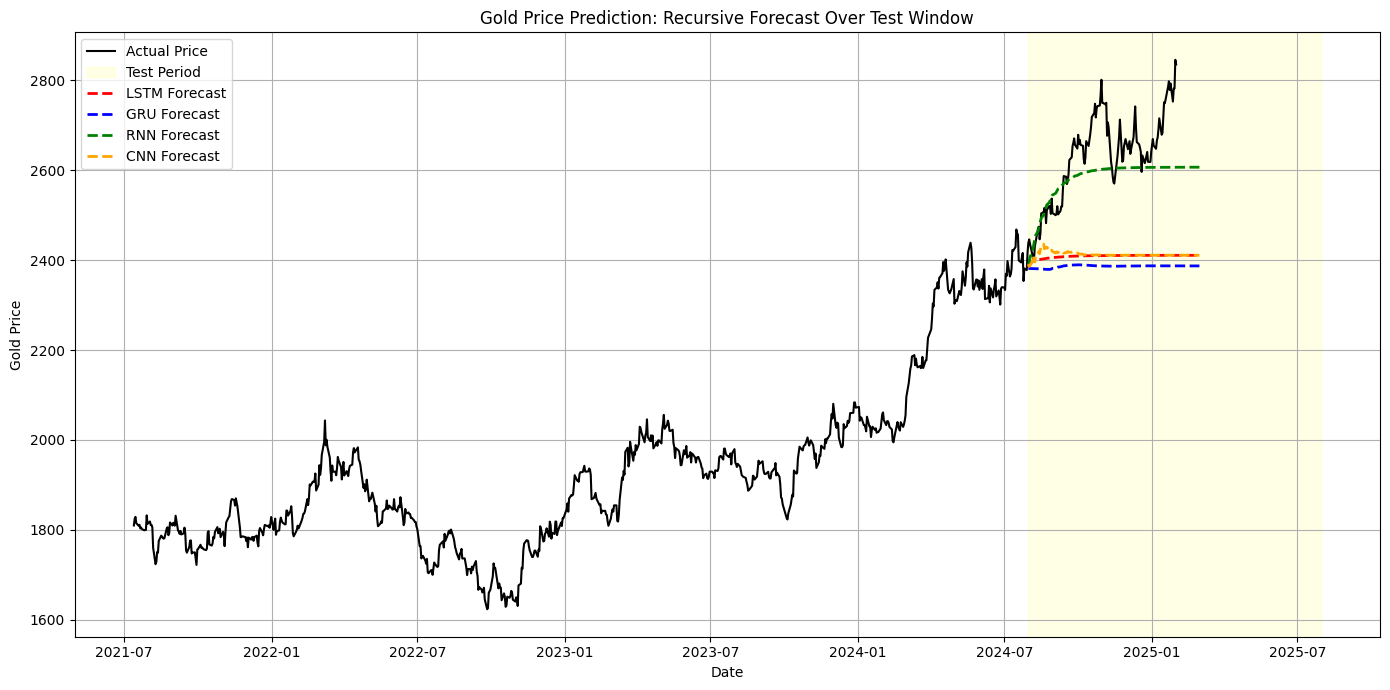

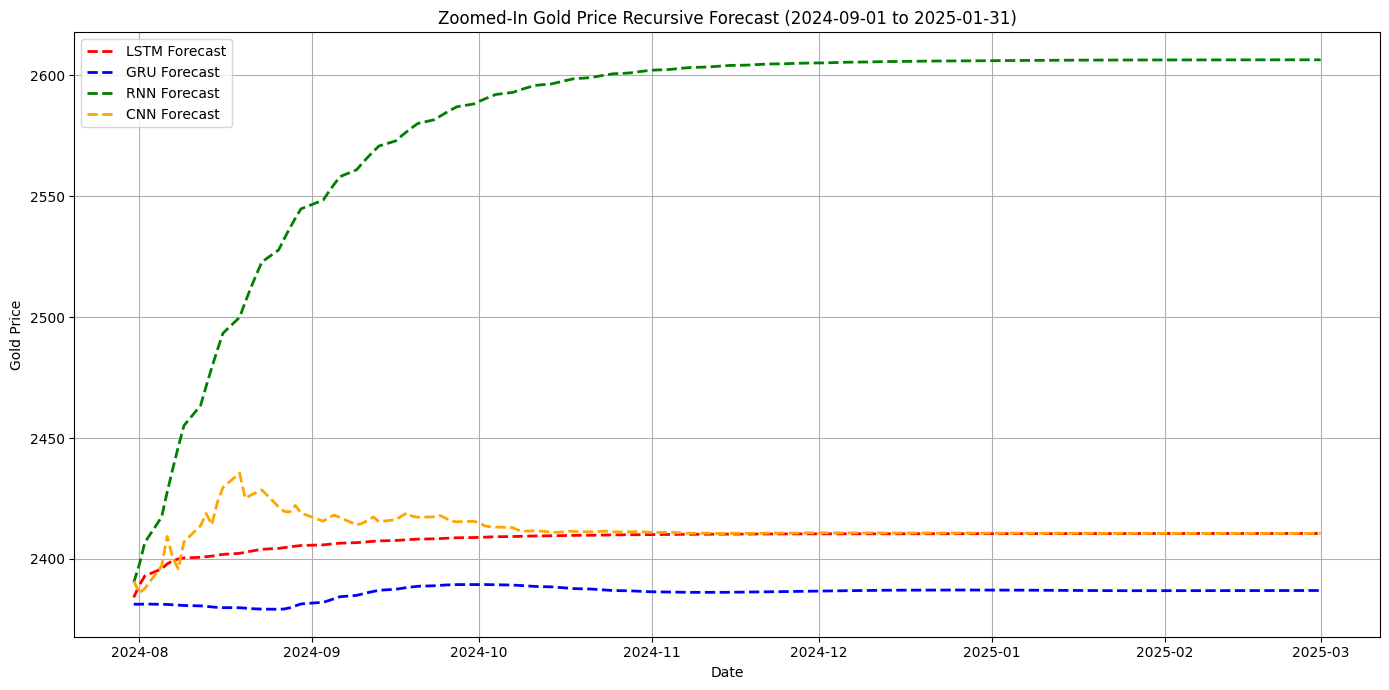

In [47]:
# Load and prepare data
df = pd.read_csv('Gold Futures Historical Data_3Yr.csv')
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Transform columns to numerical format
num_cols = df.columns.drop(['Date'])
df[num_cols] = df[num_cols].replace({',': ''}, regex=True)
df[num_cols] = df[num_cols].astype('float64')


# Prepare sequences and corresponding dates
X, y_full, dates = [], [], []
for i in range(window_width, len(data_scaled)):
    X.append(data_scaled[i - window_width:i])
    y_full.append(data_scaled[i, 0])  # Assuming 'Price' is the target
    dates.append(df['Date'].iloc[i])

X = np.array(X)
y_full = np.array(y_full)
full_dates = np.array(dates)
full_actual = inverse_transform(y_full)   # Save the actual price curve (e.g. shape (N_full,))



### PLOTTING RESULTS ###
# Plot the entire dataset along with the recursive forecast from each model over the test window.
plt.figure(figsize=(14, 7))
# Plot actual prices (inverse transformed) for all dates.
#all_prices_inv = scaler.inverse_transform(data_scaled)[:, 0]
plt.plot(full_dates, full_actual, color='black', label='Actual Price')
# Highlight the test period.
plt.axvspan(pd.to_datetime('2024-07-31'), df['Date'].iloc[-1], color='yellow', alpha=0.1, label='Test Period')
# Define colors for models.
model_colors = {
    'LSTM': 'red',
    'GRU': 'blue',
    'RNN': 'green',
    'CNN': 'orange',
}
# Plot forecast from each model.
for model_name, forecast in all_forecasts.items():
    plt.plot(test_dates, forecast, color=model_colors[model_name], linestyle='--', linewidth=2, label=f'{model_name} Forecast')
plt.title('Gold Price Prediction: Recursive Forecast Over Test Window')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Zoomed-in Plot (starting from 2024-09-01)
plt.figure(figsize=(14, 7))
for model_name, forecast in all_forecasts.items():
    plt.plot(test_dates, forecast, color=model_colors[model_name], linestyle='--', linewidth=2, label=f'{model_name} Forecast')
plt.title('Zoomed-In Gold Price Recursive Forecast (2024-09-01 to 2025-01-31)')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
